In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from statistics import median_high, median_low
import random

In [2]:
## from literature
z_head = 22.0 #cm
w_head = 15.6 #cm
v_sound = 33000 #cm/s

## Example of the two source models compared

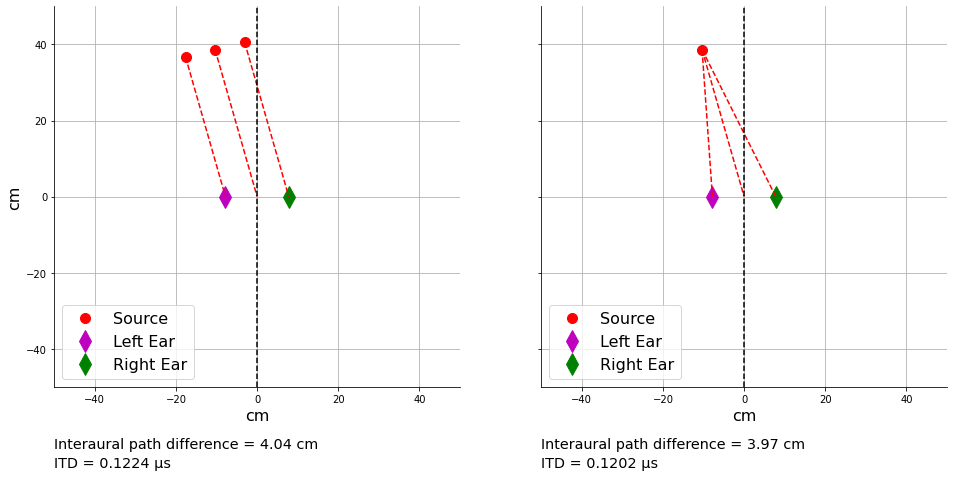

In [5]:
theta_ex_deg = 345
theta_ex = theta_ex_deg*np.pi/180
d = 40 #cm #only for the plot
left_ear = [-w_head/2,0]
right_ear = [w_head/2,0]
centre = [0,0]

# NON-POINT SOURCE (IDEAL) FORMULA
module1 = (d+(w_head/2)*np.sin(theta_ex))
module2 = (d-(w_head/2)*np.sin(theta_ex))
source0 = [d*np.sin(theta_ex), d*np.cos(theta_ex)]
source1 = [module1*np.sin(theta_ex)-w_head/2, module1*np.cos(theta_ex)]
source2 = [module2*np.sin(theta_ex)+w_head/2, module2*np.cos(theta_ex)]
delta_x_nps = abs(w_head*np.sin(theta_ex))
itd_nps = 1000*delta_x_nps/v_sound #ms

#POINT SOURCE (REAL) FORMULA
module1 = np.sqrt(d**2 + (w_head**2)/4 + w_head*d*np.sin(theta_ex))
module2 = np.sqrt(d**2 + (w_head**2)/4 - w_head*d*np.sin(theta_ex))
delta_x_ps = abs(module1 - module2)
itd_ps = 1000*delta_x_ps/v_sound

fig, ax = plt.subplots(1,2, figsize = (16,7), sharey = True)
ax[0].plot(source0[0],source0[1], 'ro', markersize = 10, label = 'Source')
ax[0].plot(source1[0],source1[1], 'ro', markersize = 10)
ax[0].plot(source2[0],source2[1], 'ro', markersize = 10)
ax[0].plot(left_ear[0],left_ear[1], 'md', markersize = 15,  label = 'Left Ear')
ax[0].plot(right_ear[0], right_ear[1], 'gd', markersize = 15, label = 'Right Ear')
ax[0].plot([source0[0],centre[0]], [source0[1],centre[1]], 'r--')
ax[0].plot([source1[0],left_ear[0]], [source1[1],left_ear[1]], 'r--')
ax[0].plot([source2[0],right_ear[0]], [source2[1],right_ear[1]], 'r--')
ax[0].axvline(centre[0], color = 'k', linestyle = 'dashed')
ax[0].grid()
ax[0].set_xlim(-50,+50)
ax[0].set_ylim(-50,+50)
#ax[0].set_title("NON-POINT SOURCE (IDEAL)")
ax[0].set_xlabel("cm", fontsize = 16)
ax[0].set_ylabel("cm", fontsize = 16)
s1 = "Interaural path difference = {} cm".format(round(delta_x_nps,2))
s2 = "ITD = {} \u03BCs".format(round(itd_nps,4))
ax[0].text(-50,-66,s1, fontsize = 'x-large')
ax[0].text(-50,-71,s2, fontsize = 'x-large')
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].legend(loc = 3, fontsize = 16)

ax[1].plot(source0[0],source0[1], 'ro', markersize = 10, label = 'Source')
ax[1].plot(left_ear[0],left_ear[1], 'md', markersize = 15, label = 'Left Ear')
ax[1].plot(right_ear[0], right_ear[1], 'gd', markersize = 15,  label = 'Right Ear')
ax[1].plot([source0[0],left_ear[0]], [source0[1],left_ear[1]], 'r--')
ax[1].plot([source0[0],right_ear[0]], [source0[1],right_ear[1]], 'r--')
ax[1].plot([source0[0],centre[0]], [source0[1],centre[1]], 'r--')
ax[1].axvline(centre[0], color = 'k', linestyle = 'dashed')
ax[1].grid()
ax[1].set_xlim(-50,+50)
ax[1].set_ylim(-50,+50)
#ax[1].set_title("POINT SOURCE (REAL)")
ax[1].set_xlabel("cm", fontsize = 16)
#ax[1].set_ylabel("cm")
s1 = "Interaural path difference = {} cm".format(round(delta_x_ps,2))
s2 = "ITD = {} \u03BCs".format(round(itd_ps,4))
plt.text(-50,-66,s1, fontsize = 'x-large')
plt.text(-50,-71,s2, fontsize = 'x-large')
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].legend(loc = 3, fontsize = 16)


# Functions

In [6]:
# Function to obtain the azimuth angle starting from the coordinates in space
def coord2angle(source):
    if source[0]>0:
        theta = np.pi/2 - np.arctan(source[1]/source[0])
    elif source[0]==0:
        if source[1]>=0: theta = 0
        else: theta = np.pi
    else: 
        theta = 3*np.pi/2 - np.arctan(source[1]/source[0])
    return(theta)

In [7]:
# Function to compute the error (expressed in terms of angle) obtained by using the Non Point Source model instead of the Point Source one

# inputs of the function are: 
#1. The initial angle [rad]
#2. The ITD computed from it using the ps model [ms]
#3. The resolution used to create the array of angles, from which an array of nps itds is computed [deg]

# outputs are: 
#1. The absolute error between the initial angle and the angle computed 
#2. The difference between the ps ITD in input and the computed nps ITD which could better approximate it [ms]
#3. The azimuth angle corresponding to this latter nps ITD [rad]
#4. The difference in length between the sound paths to the two ears (also obtained using NPS model) [cm]

def compute_error(ps_angle, ps_itd, deg_resolution):
    thetas_deg = np.arange(0, 360, deg_resolution)
    thetas = thetas_deg*np.pi/180.0
    #here I'm using formulas of the NON POINT SOURCE MODEL to create an array of ITDs mapping all the space
    deltaxs = abs(w_head*np.sin(thetas)) #cm,  
    itds = 1000*deltaxs/v_sound #ms
    
    if ps_angle < np.pi/2:
        diff = abs(itds[0:int(len(itds)/4.0)] - ps_itd)
        index = np.argmin(diff)

    elif ps_angle>=np.pi/2 and ps_angle<np.pi:
        diff = abs(itds[int(len(itds)/4.0):int(len(itds)/2.0)] - ps_itd)
        index = int(len(thetas)/4) + np.argmin(diff)

    elif ps_angle>=np.pi and ps_angle<3*np.pi/2:
        diff = abs(itds[int(len(itds)/2.0):int(3*len(itds)/4.0)] - ps_itd)
        index = int(len(thetas)/2.0) + np.argmin(diff)
        
    elif ps_angle<2*np.pi and ps_angle>=3*np.pi/2:
        diff = abs(itds[int(3*len(itds)/4.0):len(itds)] - ps_itd)
        index = int(3*len(thetas)/4) + np.argmin(diff)
   
    if ps_angle == 0:
        error = 0
    else:
        error = abs(ps_angle-thetas[index])
        
    return(error, diff[np.argmin(diff)], thetas[index], deltaxs[index])

## Error computation for a random set of source coordinates

In [8]:
source = [1,40]
#source = [[-1,1][random.randrange(2)]*random.randint(int(w_head/2), int(dim/2)), [-1,1][random.randrange(2)]*random.randint(int(w_head/2), int(dim/2))]

In [9]:
print("point source:", source, "cm\n")
theta = coord2angle(source)
theta_deg = round(theta*180/np.pi,2)
print("point source theta:", round(theta,2), "rad,", theta_deg, "deg")
#here I'm using formulas of the POINT SOURCE MODEL
d = np.linalg.norm(source)
e_mod1 = np.sqrt(d**2 + (w_head**2)/4 + w_head*d*np.sin(theta))       
e_mod2 = np.sqrt(d**2 + (w_head**2)/4 - w_head*d*np.sin(theta))
delta_x = abs(e_mod1 - e_mod2) 
itd = 1000*delta_x/v_sound
print("centre_distance:", round(d,2), "cm")
print("ears_distances: ", round(e_mod1,2), "cm", round(e_mod2,2), "cm")
print("point source delta_x:", round(delta_x,2), "cm")
print("point source itd:", round(itd,2), "ms\n")

error, diff_itd, nps_theta, nps_delta_x = compute_error(theta, itd, 0.01)

print("itd_difference:", diff_itd, "ms")
print("non point source delta_x:", round(nps_delta_x,2), "cm")
print ("non point source theta:", round(nps_theta,2), "rad", round(nps_theta*180/np.pi,2), "deg\n")
print("approximation error:", round(error,4), "rad  ",round(error*180/np.pi, 4), "deg  ")

point source: [1, 40] cm

point source theta: 0.02 rad, 1.43 deg
centre_distance: 40.01 cm
ears_distances:  40.96 cm 40.57 cm
point source delta_x: 0.38 cm
point source itd: 0.01 ms

itd_difference: 3.590133442614961e-05 ms
non point source delta_x: 0.38 cm
non point source theta: 0.02 rad 1.41 deg

approximation error: 0.0004 rad   0.0221 deg  


## Error distribution along different sources location in the horizontal plane

In [10]:
dim1 = 100 # x dimension of the space
dim2 = 100 # y dimension of the space

In [11]:
def create_colormap(dim1, dim2, s_res, w_head, z_head, im_size):
    error_m = np.zeros((dim1,dim2))
    for i in range(int(-dim1/2), int(dim1/2), s_res):
        for j in range(int(-dim2/2), int(dim2/2), s_res):
            source_m = [i,j]
            #here I'm using formulas of the POINT SOURCE MODEL
            d = np.linalg.norm(source_m)
            theta_m = coord2angle(source_m)
            e_mod1_m = np.sqrt(d**2 + (w_head**2)/4 + w_head*d*np.sin(theta_m))
            e_mod2_m = np.sqrt(d**2 + (w_head**2)/4 - w_head*d*np.sin(theta_m))
            delta_x_m = abs(e_mod1_m - e_mod2_m)
            itd_m = 1000*delta_x_m/v_sound
            error, diff_itd_m, nps_theta_m, nps_delta_x_m = compute_error(theta_m, itd_m, 0.01)
            error_m[i+int(dim1/2),j+int(dim2/2)] = error*180/np.pi          
    a = w_head/2
    b = z_head/2
    for i in range (0, dim1, 1):
        for j in range (0, dim2, 1):
            if((b**2*(i-int(dim1/2))**2 + a**2*(j-int(dim2/2))**2) < (a**2*b**2)):
                error_m[i,j] = 0
    error_m = ndimage.rotate(error_m, +90, mode='constant')  
    viridis = plt.cm.get_cmap('viridis', 100)
    fig, ax = plt.subplots(figsize=(im_size,im_size))
    im = ax.imshow(error_m,cmap=viridis, extent = (-int(dim1/2), int(dim1/2),-int(dim2/2),int(dim2/2)))
    #plt.title("Angle error [deg]")
    plt.xlabel("cm", fontsize = 16)
    plt.ylabel("cm", fontsize = 16)
    plt.colorbar(im,fraction=0.046, pad=0.04)
    return(error_m)

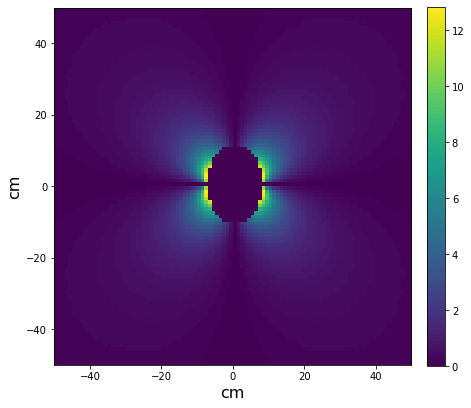

In [12]:
matrix= create_colormap(dim1, dim2, 1, w_head, z_head, 7)

In [13]:
s_res = 1

In [14]:
matrix.sum()/(len(matrix)**2)

0.6644998324173487

# Image for the thesis

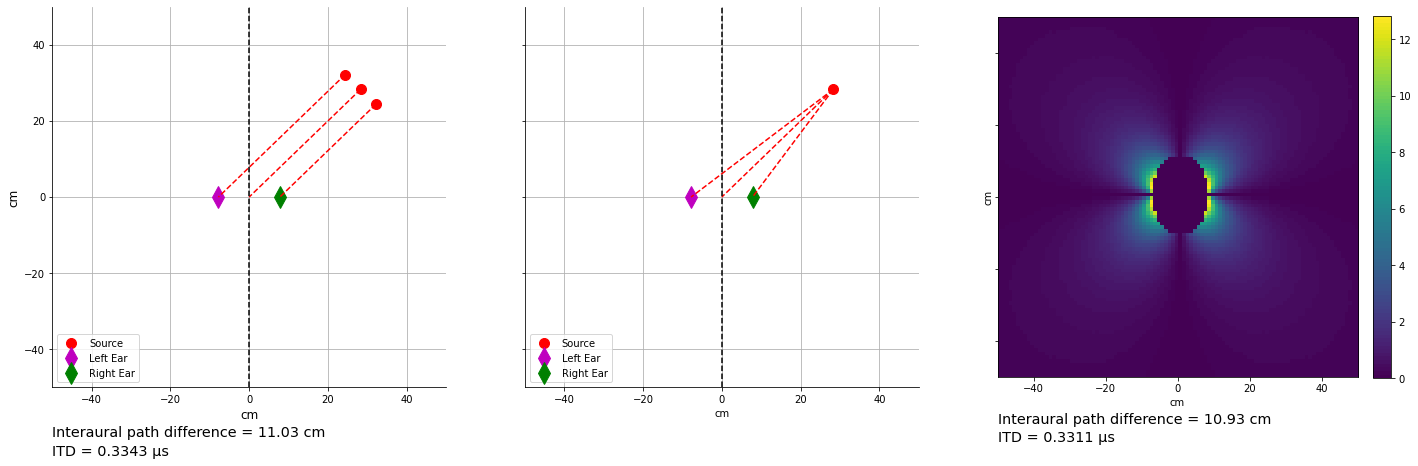

In [15]:
theta_ex_deg = 45
theta_ex = theta_ex_deg*np.pi/180
d = 40 #cm #only for the plot
left_ear = [-w_head/2,0]
right_ear = [w_head/2,0]
centre = [0,0]

# NON-POINT SOURCE (IDEAL) FORMULA
module1 = (d+(w_head/2)*np.sin(theta_ex))
module2 = (d-(w_head/2)*np.sin(theta_ex))
source0 = [d*np.sin(theta_ex), d*np.cos(theta_ex)]
source1 = [module1*np.sin(theta_ex)-w_head/2, module1*np.cos(theta_ex)]
source2 = [module2*np.sin(theta_ex)+w_head/2, module2*np.cos(theta_ex)]
delta_x_nps = abs(w_head*np.sin(theta_ex))
itd_nps = 1000*delta_x_nps/v_sound #ms

#POINT SOURCE (REAL) FORMULA
module1 = np.sqrt(d**2 + (w_head**2)/4 + w_head*d*np.sin(theta_ex))
module2 = np.sqrt(d**2 + (w_head**2)/4 - w_head*d*np.sin(theta_ex))
delta_x_ps = abs(module1 - module2)
itd_ps = 1000*delta_x_ps/v_sound

fig, ax = plt.subplots(1,3, figsize = (24,7), sharey = True)
ax[0].plot(source0[0],source0[1], 'ro', markersize = 10, label = 'Source')
ax[0].plot(source1[0],source1[1], 'ro', markersize = 10)
ax[0].plot(source2[0],source2[1], 'ro', markersize = 10)
ax[0].plot(left_ear[0],left_ear[1], 'md', markersize = 15,  label = 'Left Ear')
ax[0].plot(right_ear[0], right_ear[1], 'gd', markersize = 15, label = 'Right Ear')
ax[0].plot([source0[0],centre[0]], [source0[1],centre[1]], 'r--')
ax[0].plot([source1[0],left_ear[0]], [source1[1],left_ear[1]], 'r--')
ax[0].plot([source2[0],right_ear[0]], [source2[1],right_ear[1]], 'r--')
ax[0].axvline(centre[0], color = 'k', linestyle = 'dashed')
ax[0].grid()
ax[0].set_xlim(-50,+50)
ax[0].set_ylim(-50,+50)
#ax[0].set_title("NON-POINT SOURCE (IDEAL)")
ax[0].set_xlabel("cm", fontsize = 12)
ax[0].set_ylabel("cm", fontsize = 12)
s1 = "Interaural path difference = {} cm".format(round(delta_x_nps,2))
s2 = "ITD = {} \u03BCs".format(round(itd_nps,4))
ax[0].text(-50,-63,s1, fontsize = 'x-large')
ax[0].text(-50,-68,s2, fontsize = 'x-large')
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].legend(loc = 3)

ax[1].plot(source0[0],source0[1], 'ro', markersize = 10, label = 'Source')
ax[1].plot(left_ear[0],left_ear[1], 'md', markersize = 15, label = 'Left Ear')
ax[1].plot(right_ear[0], right_ear[1], 'gd', markersize = 15,  label = 'Right Ear')
ax[1].plot([source0[0],left_ear[0]], [source0[1],left_ear[1]], 'r--')
ax[1].plot([source0[0],right_ear[0]], [source0[1],right_ear[1]], 'r--')
ax[1].plot([source0[0],centre[0]], [source0[1],centre[1]], 'r--')
ax[1].axvline(centre[0], color = 'k', linestyle = 'dashed')
ax[1].grid()
ax[1].set_xlim(-50,+50)
ax[1].set_ylim(-50,+50)
#ax[1].set_title("POINT SOURCE (REAL)")
ax[1].set_xlabel("cm")
#ax[1].set_ylabel("cm")
s1 = "Interaural path difference = {} cm".format(round(delta_x_ps,2))
s2 = "ITD = {} \u03BCs".format(round(itd_ps,4))
plt.text(-50,-63,s1, fontsize = 'x-large')
plt.text(-50,-68,s2, fontsize = 'x-large')
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].legend(loc = 3)


#plt.title("Angle error [deg]")
error_m = np.zeros((dim1,dim2))
for i in range(int(-dim1/2), int(dim1/2), s_res):
    for j in range(int(-dim2/2), int(dim2/2), s_res):
        source_m = [i,j]
        #here I'm using formulas of the POINT SOURCE MODEL
        d = np.linalg.norm(source_m)
        theta_m = coord2angle(source_m)
        e_mod1_m = np.sqrt(d**2 + (w_head**2)/4 + w_head*d*np.sin(theta_m))
        e_mod2_m = np.sqrt(d**2 + (w_head**2)/4 - w_head*d*np.sin(theta_m))
        delta_x_m = abs(e_mod1_m - e_mod2_m)
        itd_m = 1000*delta_x_m/v_sound
        error, diff_itd_m, nps_theta_m, nps_delta_x_m = compute_error(theta_m, itd_m, 0.01)
        error_m[i+int(dim1/2),j+int(dim2/2)] = error*180/np.pi          
a = w_head/2
b = z_head/2
for i in range (0, dim1, 1):
    for j in range (0, dim2, 1):
        if((b**2*(i-int(dim1/2))**2 + a**2*(j-int(dim2/2))**2) < (a**2*b**2)):
            error_m[i,j] = 0
error_m = ndimage.rotate(error_m, +90, mode='constant')  
viridis = plt.cm.get_cmap('viridis', 100)
im = ax[2].imshow(error_m,cmap=viridis, extent = (-int(dim1/2), int(dim1/2),-int(dim2/2),int(dim2/2)))
#ax[1].title("Angle error [deg]")
ax[2].set_xlabel("cm")
ax[2].set_ylabel("cm")
fig.colorbar(im,fraction=0.046, pad=0.04)
